### DATA COLLECTION

### IMPORTING NECESSARY LIBRARIES

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
import cv2
import time
import json
from keras.models import Model , Sequential , load_model
from keras.layers import *
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.applications.resnet50 import ResNet50 , preprocess_input , decode_predictions

2024-04-20 11:44:05.068492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 11:44:05.068591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 11:44:05.320703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### UNDERSTANDING THE DATA

In [5]:
def readTextFile(file_path):
    with open(file_path) as f:
      return f.read()

doc = readTextFile("/kaggle/input/flickr-data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")

lines = doc.split("\n")[:-1]   
print(len(lines))

40460


In [6]:
lines[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

Create a dictionary named “descriptions” 

In [7]:
descriptions = {}

for line in lines:
    
    tokens = line.split('\t')
    
    img_name , caption = tokens[0] , tokens[1]
    img_name = img_name.split('.')[0]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
        
    descriptions[img_name].append(caption)

In [8]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [9]:
len(descriptions)   

8092

### DATA CLEANING

In [11]:
def clean_text(sentence):
    
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+' , ' ' , sentence)
    sentence = [word for word in sentence.split() if len(word)>1]
    sentence = " ".join(sentence)
    return sentence


for img_id , caption_list in descriptions.items():
    for caption in range(len(caption_list)):
        caption_list[caption] = clean_text(caption_list[caption])

descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [12]:
with open("descriptions.txt" , "w") as f:
    f.write(str(descriptions))

In [13]:
with open("descriptions.txt" , "r") as f:
    descriptions = f.read()

type(descriptions)

str

In [14]:
json_acceptable_str = descriptions.replace("'" , "\"")
descriptions = json.loads(json_acceptable_str)
type(descriptions)

dict

In [15]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

### CREATE VOCAB

In [16]:
total_words = []

for key, caption_list in descriptions.items():
    [total_words.append(word) for caption in caption_list for word in caption.split()]

print("Total no of words across all image captions: %d" %(len(total_words)))

Total no of words across all image captions: 373837


In [17]:
total_words[:10]

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']

In [18]:
unique_words = set()

for key in descriptions.keys():
    [unique_words.update(caption.split()) for caption in descriptions[key]]

print("Total no of unique words across all image captions: %d" %(len(unique_words))) 

Total no of unique words across all image captions: 8424


In [19]:
word_count_threshold = 10
freq_counts = {}
for word in total_words:
    freq_counts[word] = freq_counts.get(word , 0) + 1 
print(len(freq_counts.keys()))

8424


In [20]:
sorted_freq_count = sorted(freq_counts.items() , reverse = True , key = lambda x:x[1])

In [21]:
print(sorted_freq_count[:10])

[('in', 18987), ('the', 18420), ('on', 10746), ('is', 9345), ('and', 8863), ('dog', 8138), ('with', 7765), ('man', 7275), ('of', 6723), ('two', 5643)]


In [22]:
sorted_freq_count = [x for x in sorted_freq_count if x[1] > word_count_threshold]

vocabulary = [x[0] for x in sorted_freq_count]
print("Final Vocab Size: %d" %len(vocabulary))

Final Vocab Size: 1845


### PREPARE THE TRAIN AND TEST DATA

In [23]:
train_file_data = readTextFile("/kaggle/input/flickr-data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/kaggle/input/flickr-data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [24]:
train_id = [id.split(".")[0] for id in train_file_data.split("\n")[:-1]]

In [25]:
print("No of Image Id's in Train Data: %d" %len(train_id))

No of Image Id's in Train Data: 6000


In [26]:
train_id

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154',
 '2851304910_b5721199bc',
 '3423802527_94bd2b23b0',
 '3356369156_074750c6cc',
 '2294598473_40637b5c04',
 '1191338263_a4fa073154',
 '2380765956_6313d8cae3',
 '3197891333_b1b0fd1702',
 '3119887967_271a097464',
 '2276499757_b44dc6f8ce',
 '2506892928_7e79bec613',
 '2187222896_c206d63396',
 '2826769554_85c90864c9',
 '3097196395_ec06075389',
 '3603116579_4a28a932e2',
 '3339263085_6db9fd0981',
 '2532262109_87429a2cae',
 '2076906555_c20dc082db',
 '2502007071_82a8c639cf',
 '3113769557_9edbb8275c',
 '3325974730_3ee192e4ff',
 '1655781989_b15ab4cbff',
 '1662261486_db967930de',
 '2410562803_56ec09f41c',
 '2469498117_b4543e1460',
 '69710415_5c2bfb1058',
 '3414734842_beb543f400',
 '3006217970_90b42e6b27',
 '2192411521_9c7e488c5e',
 '3535879138_928

In [27]:
test_file_data[-1]

'\n'

In [28]:
test_id = [id.split(".")[0] for id in test_file_data.split("\n")[:-1]]
print("No of Image Id's in Test Data: %d" %len(test_id))

No of Image Id's in Test Data: 1000


In [29]:
test_id

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01',
 '2654514044_a70a6e2c21',
 '2339106348_2df90aa6a9',
 '256085101_2c2617c5d0',
 '280706862_14c30d734a',
 '3072172967_630e9c69d0',
 '3482062809_3b694322c4',
 '1167669558_87a8a467d6',
 '2847615962_c330bded6e',
 '3344233740_c010378da7',
 '2435685480_a79d42e564',
 '3110649716_c17e14670e',
 '2511019188_ca71775f2d',
 '2521770311_3086ca90de',
 '2723477522_d89f5ac62b',
 '2218609886_892dcd6915',
 '3745451546_fc8ec70cbd',
 '2844018783_524b08e5aa',
 '3100251515_c68027cc22',
 '2207244634_1db1a1890b',
 '2943023421_e297f05e11',
 '3286822339_5535af6b93',
 '2479652566_8f9fac8af5',
 '1394368714_3bc7c19969',
 '872622575_ba1d3632cc',
 '2309860995_c2e2a0feeb',
 '241347204_007d83e252',
 '3502343542_f9b46688e5',
 '757332692_6866ae545c',
 '2748729903_3c7c920c4d',
 '494792770_2c5f767ac0',
 '3213992947_3f3f967a9f',
 '2295750198_6d152d7ceb',
 '2358898017_24496b80e8',
 '3222055946_45f7293

In [30]:
train_descriptions = {}
for img_id in train_id:
    train_descriptions[img_id] = []
    for caption in descriptions[img_id]:
        caption_to_append = "startseq "+caption+" endseq"
        train_descriptions[img_id].append(caption_to_append)

print("Train Descriptions: %d" %len(train_descriptions))      

Train Descriptions: 6000


In [31]:
train_descriptions = {}
for img_id in train_id:
    train_descriptions[img_id] = descriptions.get(img_id)
for key , caption_list in train_descriptions.items():
    for caption in range(len(caption_list)):
        caption_list[caption] = 'startseq ' + caption_list[caption] + ' endseq' 

In [32]:
train_descriptions['3522749949_fb615cee47']

['startseq man in black and red jersey is approaching soccer ball on field endseq',
 'startseq man on soccer field in uniform about to kick soccer ball endseq',
 'startseq soccer player with black and red striped uniform gets ready to kick the soccer ball endseq',
 'startseq david beckham player playing soccer on field endseq',
 'startseq the player is kicking soccer ball on the grass field endseq']

### Image Features Extraction using Transfer Learning (ResNet-50 Model)

In [33]:
model = ResNet50(weights = 'imagenet' , input_shape = (224, 224, 3))
model.summary()

102967424/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

In [35]:
model_new = Model(model.input , model.layers[-2].output)
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [37]:
def preprocess_image(img):
    img = image.load_img(img , target_size = (224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img , axis = 0)
    img = preprocess_input(img)   
    return img

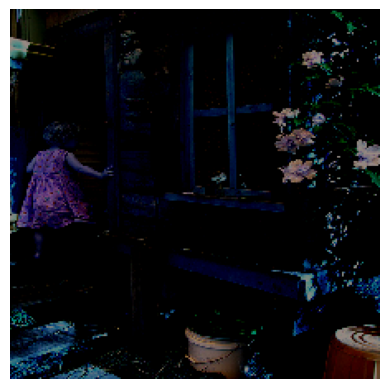

In [38]:
im = preprocess_image(img_path+"/1000268201_693b08cb0e.jpg")
plt.imshow(im[0]/255.0)   
plt.axis('off')
plt.show()

In [39]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)           
    feature_vector = feature_vector.reshape((-1, ))
    return feature_vector

In [ ]:
encode_image(img_path+"/1000268201_693b08cb0e.jpg")

1/1 [==============================] - 4s 4s/step


array([0.0653656 , 0.16782705, 0.32518396, ..., 0.05111529, 0.3281786 ,
       1.0043348 ], dtype=float32)

In [41]:
IMG_PATH = '/kaggle/input/flickr-data/Flickr_Data/Images'

In [42]:
start = time.time()
encoded_train_data = {}

for ix, img_id in enumerate(train_id):
    img_path = IMG_PATH +"/"+ img_id + ".jpg"
    encoded_train_data[img_id] = encode_image(img_path)
    
    if ix%500 == 0:
        print("Encoding in Progress Step Time %d" %ix)
    
end = time.time()
print("Time Elapsed: " , end-start)

1/1 [==============================] - 0s 24ms/step
Encoding in Progress Step Time 0
1/1 [==============================] - 0s 23ms/step
Encoding in Progress Step Time 500
1/1 [==============================] - 0s 21ms/step
Encoding in Progress Step Time 1000
1/1 [==============================] - 0s 21ms/step
Encoding in Progress Step Time 1500
1/1 [==============================] - 0s 21ms/step
Encoding in Progress Step Time 2000
1/1 [==============================] - 0s 21ms/step
Encoding in Progress Step Time 2500
1/1 [==============================] - 0s 22ms/step
Encoding in Progress Step Time 3000
1/1 [==============================] - 0s 21ms/step
Encoding in Progress Step Time 3500
1/1 [==============================] - 0s 22ms/step
Encoding in Progress Step Time 4000
1/1 [==============================] - 0s 21ms/step
Encoding in Progress Step Time 4500
1/1 [==============================] - 0s 23ms/step
Encoding in Progress Step Time 5000
1/1 [==============================]

In [43]:
with open("encoded_train_img_features.pkl" , "wb") as file:
    pickle.dump(encoded_train_data , file)

In [44]:
train_features = pickle.load(open("encoded_train_img_features.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [45]:
start = time.time()
encoded_test_data = {}

for ix, img_id in enumerate(test_id):
    img_path = IMG_PATH +"/"+ img_id + ".jpg"
    encoded_test_data[img_id] = encode_image(img_path)
    
    if ix%500 == 0:
        print("Test Encoding in Progress Step Time %d" %ix)
    
end = time.time()
print("Time Elapsed: " , end-start) 

1/1 [==============================] - 0s 25ms/step
Test Encoding in Progress Step Time 0
1/1 [==============================] - 0s 21ms/step
Test Encoding in Progress Step Time 500
1/1 [==============================] - 0s 21ms/step
Time Elapsed:  85.69630408287048


In [46]:
with open("encoded_test_img_features.pkl" , "wb") as file:
    pickle.dump(encoded_test_data , file)

In [47]:
with open("encoded_test_img_features.pkl" , "rb") as f:
    encoded_test_data = pickle.load(f)

### PREPROCESSING CAPTIONS

In [48]:
len(vocabulary)

1845

In [49]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(vocabulary):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [50]:
print(word_to_idx['dog'])
print(idx_to_word[6])

6
dog


In [51]:
word_to_idx['startseq'] = 1846
idx_to_word[1846] = 'startseq'

word_to_idx['endseq'] = 1847
idx_to_word[1847] = 'endseq'

vocab_size = len(word_to_idx) + 1             
print("Final Vocab Size: %d" %vocab_size)

Final Vocab Size: 1848


In [52]:
max_len = 0

for key in descriptions.keys():
    for caption in descriptions[key]:
        max_len = max(max_len , len(caption.split()))
        
print('Max Description Length: %d' %max_len)

Max Description Length: 35


### CUSTOM DATA GENERATOR TO LOAD DATA IN BATCHES

In [ ]:
def data_generator(train_descriptions , encoded_train_data , word_to_idx , max_len , batch_size):
    
    x1 , x2 , y = [] , [] , []
    n = 0
    
    while True:
        for key, caption_list in train_descriptions.items():
            n += 1
            
            photo = encoded_train_data[key]
            
            for caption in caption_list:
                seq = [word_to_idx[word] for word in caption.split() if word in word_to_idx]
                
                for i in range(1 , len(seq)):
                    input_seq , output_seq = seq[0:i] , seq[i]
                    input_seq = pad_sequences([input_seq], maxlen=max_len, value = 0, padding = 'post')[0] 
                    output_seq = to_categorical([output_seq] , num_classes =  vocab_size)[0]
                    x1.append(photo)      
                    x2.append(input_seq)  
                    y.append(output_seq)  
                    
            if n == batch_size:
                
                yield ([np.array(x1) , np.array(x2)] , np.array(y))  
                x1 , x2 , y = [] , [] , [] 
                n = 0

### WORD EMBEDDINGS [Transfer Learning]

In [54]:
file = open("/kaggle/input/glove6b50dtxt/glove.6B.50d.txt" , encoding = "utf8")

In [55]:
for line in file:
    print(line)
    break

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581



In [56]:
embeddings_index = {}   

for line in file:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:] , dtype = 'float')
    embeddings_index[word] = word_embedding
    
file.close()

In [57]:
def get_embedding_matrix():
    emb_dim = 50
    embedding_matrix = np.zeros((vocab_size , emb_dim))
    
    for idx, word in idx_to_word.items():
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
            
    return embedding_matrix

In [58]:
embeddings_matrix = get_embedding_matrix()
embeddings_matrix.shape

(1848, 50)

### DEFINE MODEL ARCHITECTURE

In [59]:
input_img_features = Input(shape = (2048,))   
fe1 = Dropout(0.3)(input_img_features)
fe2 = Dense(256, activation='relu')(fe1)  

input_captions = Input(shape = (max_len,)) 
se1 = Embedding(vocab_size, 50, mask_zero=True)(input_captions)   
se2 = Dropout(0.3)(se1)
se3 = LSTM(256)(se2)   

decoder1 = add([fe2 , se3])       
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)  

model = Model(inputs = [input_img_features, input_captions], outputs = outputs)

In [60]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 50)               92400     ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [61]:
model.layers[2].set_weights([embeddings_matrix])
model.layers[2].trainable = False

In [62]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [64]:
len(train_descriptions)

6000

### TRAINING

In [65]:
epochs = 10
batch_size = 3
steps_per_epoch = len(train_descriptions)//batch_size

In [66]:
for i in range(epochs):
    generator = data_generator(train_descriptions , encoded_train_data , word_to_idx , max_len , batch_size)
    model.fit(generator , steps_per_epoch = steps_per_epoch , epochs = 1)

I0000 00:00:1713614116.757124     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2000/2000 [==============================] - 19s 9ms/step - loss: 2.7942


In [67]:
j = 11
epochs=10
for i in range(epochs):
    generator = data_generator(train_descriptions , encoded_train_data , word_to_idx , max_len , batch_size)
    model.fit(generator , steps_per_epoch = steps_per_epoch , epochs = 1)
    model.save('model_weights_'+str(j)+'.h5')
    j += 1

   6/2000 [..............................] - ETA: 20s - loss: 2.6635

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 19s 9ms/step - loss: 2.5817


In [68]:
model.optimizer.lr = 0.0001
epochs = 5
batch_size = 6
steps_per_epoch = len(train_descriptions)//batch_size

In [69]:
for i in range(epochs):
    generator = data_generator(train_descriptions , encoded_train_data , word_to_idx , max_len , batch_size)
    model.fit(generator , steps_per_epoch = steps_per_epoch , epochs = 1)
    model.save('model_weights_'+str(j)+'.h5')
    j += 1

1000/1000 [==============================] - 15s 15ms/step - loss: 2.4593


In [70]:
model.load_weights('model_weights_25.h5')

### PREDICTIONS

In [71]:
def predict_caption_using_greedySearch(photo):
    
    inp_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_idx[word] for word in inp_text.split() if word in word_to_idx]
        sequence = pad_sequences([sequence] , maxlen = max_len , padding = 'post')
        
        pred_label = model.predict([photo , sequence])
        pred_label = pred_label.argmax()      
        pred_word = idx_to_word[pred_label]  
    
        inp_text += " " + pred_word   
        if pred_word == "endseq":
            break

    final_caption = inp_text.split(' ')[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

1/1 [==============================] - 0s 21ms/step


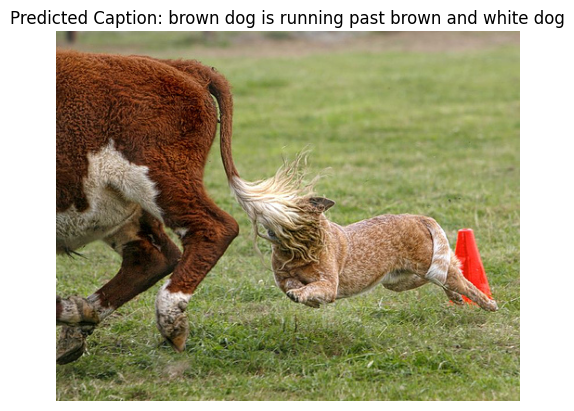

1/1 [==============================] - 0s 21ms/step


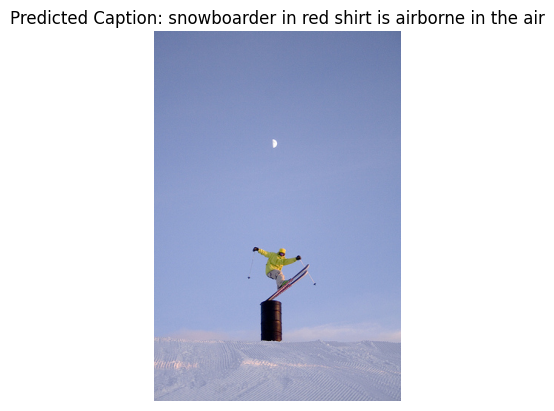

1/1 [==============================] - 0s 21ms/step


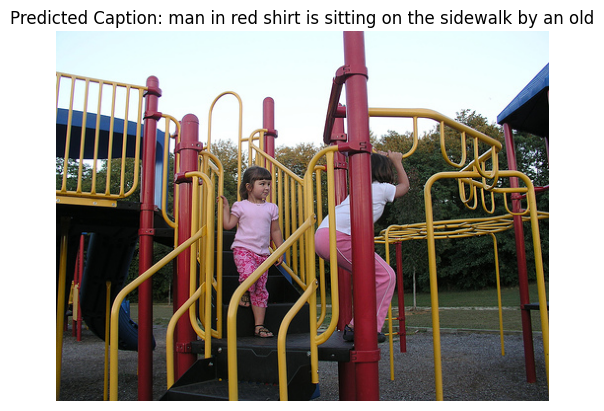

1/1 [==============================] - 0s 21ms/step


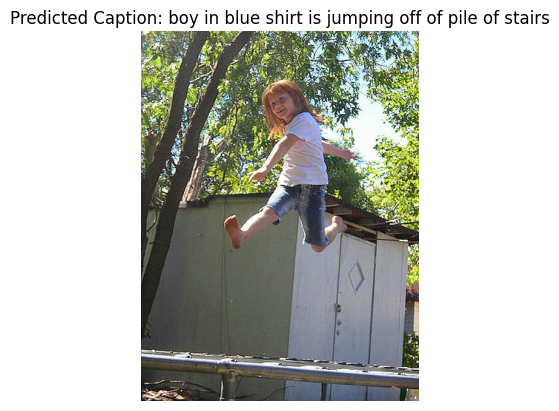

1/1 [==============================] - 0s 21ms/step


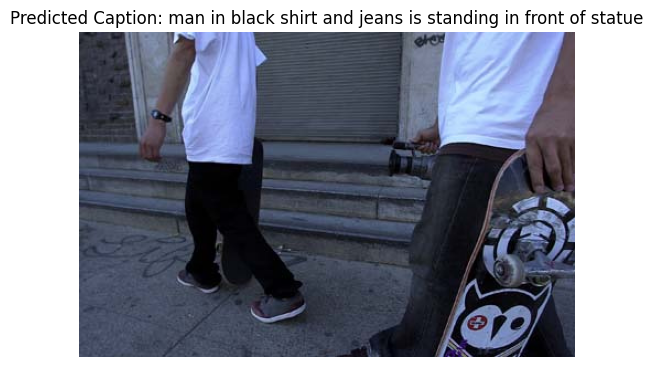

1/1 [==============================] - 0s 20ms/step


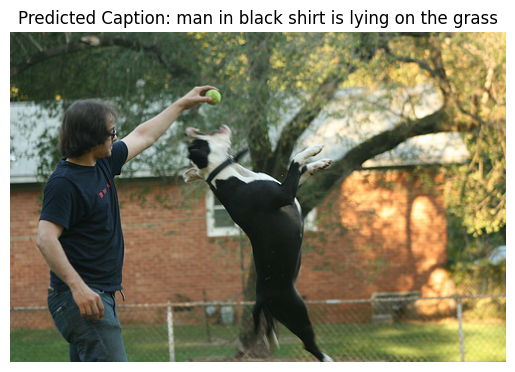

1/1 [==============================] - 0s 20ms/step


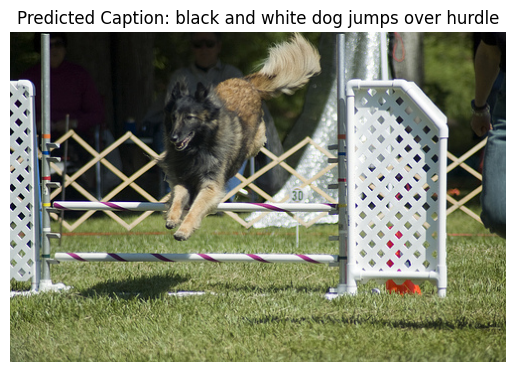

1/1 [==============================] - 0s 21ms/step


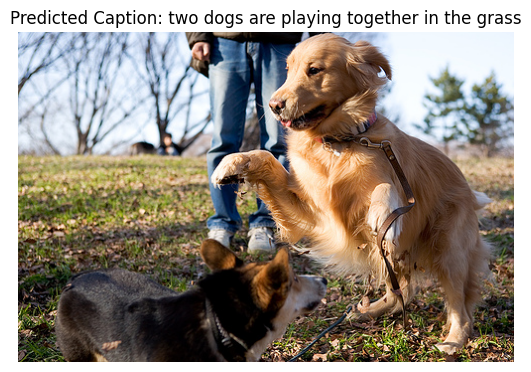

1/1 [==============================] - 0s 21ms/step


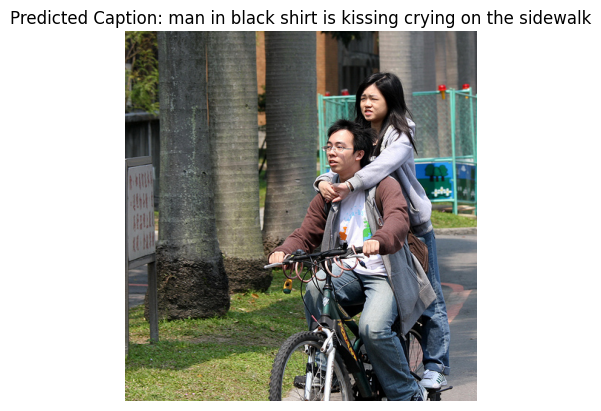

1/1 [==============================] - 0s 20ms/step


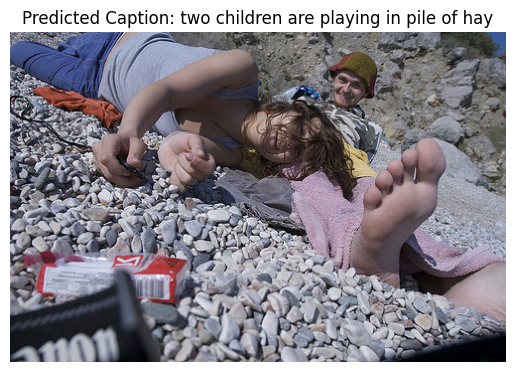

1/1 [==============================] - 0s 20ms/step


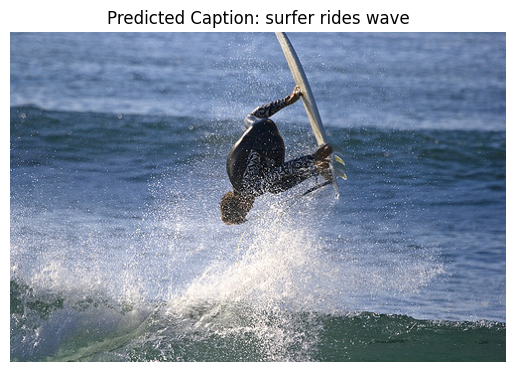

1/1 [==============================] - 0s 20ms/step


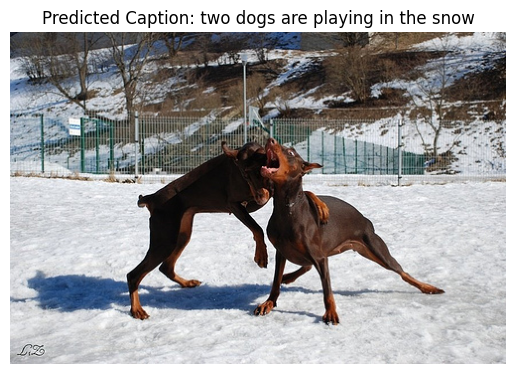

1/1 [==============================] - 0s 20ms/step


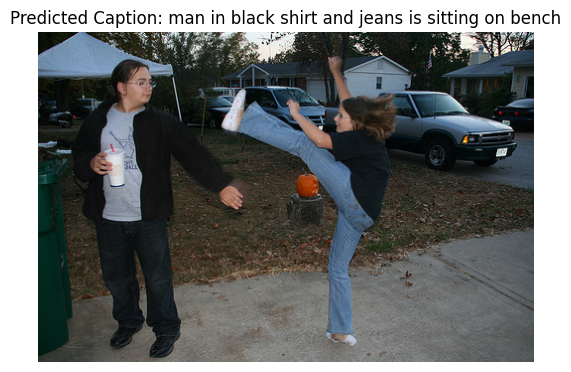

1/1 [==============================] - 0s 20ms/step


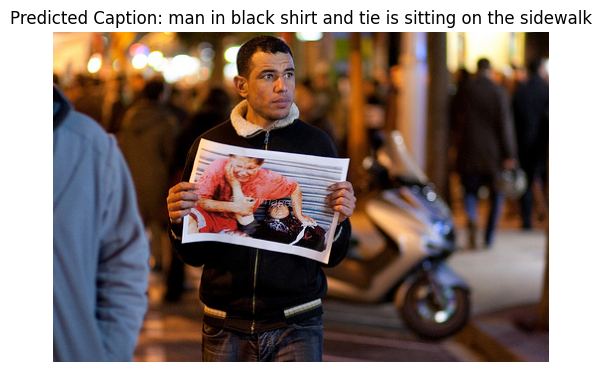

1/1 [==============================] - 0s 19ms/step


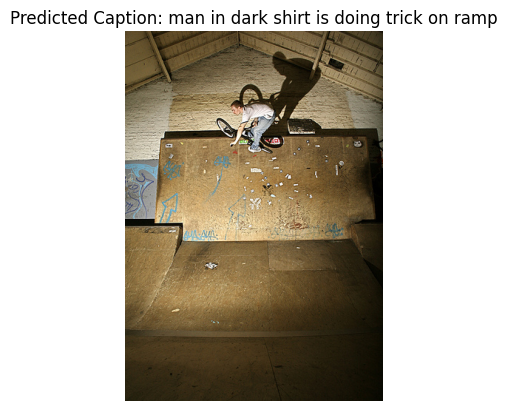

In [ ]:
IMG_PATH = '/kaggle/input/flickr-data/Flickr_Data/Images'

for i in range(15):
    idx = np.random.randint(0, 1000)
    
    all_test_images = list(encoded_test_data.keys())
    test_img_id = all_test_images[idx]
    test_img_vec = encoded_test_data[test_img_id].reshape((1, 2048))  
  
    output_caption = predict_caption_using_greedySearch(test_img_vec)

    img = plt.imread(IMG_PATH +"/"+ test_img_id + ".jpg")
    plt.imshow(img)
    plt.title("Predicted Caption: " + output_caption)
    plt.axis('off')
    plt.show()